#Generative Question Answering

##Install and Import the Libraries

Mount Google Drive and move the working folder to the one containing the dataset (**Note:** this may have to be changed according to the structure of your folders).

In [1]:
import os
from google.colab import drive

# Mount the Google drive storage
drive.mount('/content/drive')

# Move to the directory with the notebooks and the data set
# (note, you may need to change this path such that it leads to the folder that contains the dataset)
os.chdir('/content/drive/MyDrive/')

# Check the currect working directory
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive'

Let's set the device we will use...

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

...and download some libraries.

In [3]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 17.4 MB/s eta 0:00:00


## Loading the Dataset (SQuAD 1.1 or SQuAD 2.0)

Load the json files

In [4]:
import json
def load_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data['data']

train_raw = load_data('train-v2.0.json')

valid_raw = load_data('dev-v2.0.json')

The structure of the training dataset is as follows:
- We have a list of main topics
- Each topic has a title and a list of paragraphs
- Each paragraph consists of a context and a list of questions and answers with the initial position of the first character of the answer in the context

The structure of the validation dataset is the same as that of the training dataset except that given a question we can have more plausible answers for that question, therefore we have a list of answers and start of positions for the first characters

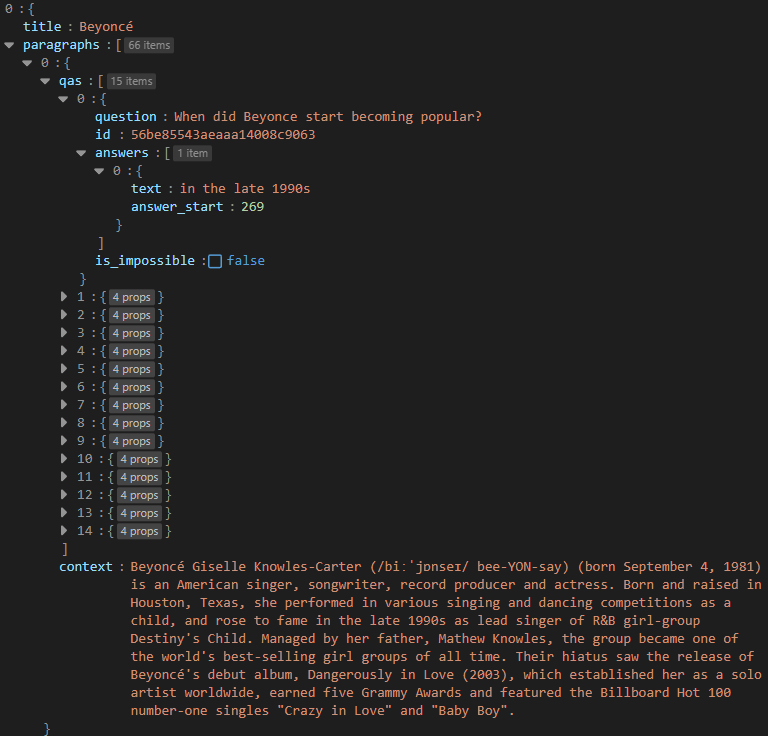


Let's see an example. The following prints the first document in the dataset, whcih is about Beyoncé.

In [5]:
print("Structure and content of the topic about Beyoncé")
train_raw[0:1]

Structure and content of the topic about Beyoncé


[{'title': 'Beyoncé',
  'paragraphs': [{'qas': [{'question': 'When did Beyonce start becoming popular?',
      'id': '56be85543aeaaa14008c9063',
      'answers': [{'text': 'in the late 1990s', 'answer_start': 269}],
      'is_impossible': False},
     {'question': 'What areas did Beyonce compete in when she was growing up?',
      'id': '56be85543aeaaa14008c9065',
      'answers': [{'text': 'singing and dancing', 'answer_start': 207}],
      'is_impossible': False},
     {'question': "When did Beyonce leave Destiny's Child and become a solo singer?",
      'id': '56be85543aeaaa14008c9066',
      'answers': [{'text': '2003', 'answer_start': 526}],
      'is_impossible': False},
     {'question': 'In what city and state did Beyonce  grow up? ',
      'id': '56bf6b0f3aeaaa14008c9601',
      'answers': [{'text': 'Houston, Texas', 'answer_start': 166}],
      'is_impossible': False},
     {'question': 'In which decade did Beyonce become famous?',
      'id': '56bf6b0f3aeaaa14008c9602',
    

The dataset contains both questions that are answerable (already contained in the first version of the dataset, SQuAD 1.1) and questions that are unanswerable. This last part was added in the most recent version of the dataset, SQuAD 2.0. It can be downloaded at: https://rajpurkar.github.io/SQuAD-explorer/

The following attribute allows to load the correct version of the dataset. Choose:
 - `True`: SQuAD 2.0
 - `False`: SQuAD 1.1

In [6]:
want_unanswerable = True # True: unanswerable questions are considered (Squad 2), False: thery are not cosidered (Squad 1)

### Train dataset

We create three lists, one for each field we are interested in: context, question and answer. For the training set, the dataset only contains one answer for each question.

In [7]:
def extract_train_dataset(data, unanswerable):
    # initialise output lists
    contexts = []
    questions = []
    answers = []
    
    for article in data:
        for paragraph in article['paragraphs']: 
            for qas in paragraph['qas']:
                if qas['is_impossible'] == False: #answerable questions
                    contexts.append(paragraph['context']) #context is duplicated for as many times as the number of questions: this simplifies the training phase
                    questions.append(qas['question'])
                    answers.append(qas['answers'][0]['text'])
                elif unanswerable == True: #SQuAD 2.0
                    contexts.append(paragraph['context']) #context is duplicated for as many times as the number of questions: this simplifies the training phase
                    questions.append(qas['question'])
                    answers.append(" ") #empty answer in case of unanswerable question

    return contexts, questions, answers

train_dataset_contexts, train_dataset_questions, train_dataset_answers = extract_train_dataset(train_raw, want_unanswerable)

To check that this worked, let's see the answer to the first question about the first context.

In [8]:
print(train_dataset_contexts[0])
print(train_dataset_questions[0])
print(train_dataset_answers[0])

Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
When did Beyonce start becoming popular?
in the late 1990s


### Validation dataset

The extraction of the validation dataset is slightly different with respect to the previous one. In this case a list of dictionaries will be easier to handle and the `id` field is saved also. Furthermore, notice that in this case more answers are collected: this passage is essential for the evaluation part, since more possible answers to a single question will be compared to the generated one. 
Note also that the `answer_start` column is considered: this was useful for the Question Answering task (see "Question Answering" notebook), not here, but it is still required to compute the metrics, so it is leaved.

In [9]:
def extract_valid_dataset(data, unanswerable):
    dataset = []

    for article in data:
        for paragraph in article['paragraphs']:
            for qas in paragraph['qas']:
                if qas['is_impossible'] == False: 
                    list_answers = []
                    list_answers_start = []
                    for a in qas['answers']:
                        list_answers.append(a['text'])
                        list_answers_start.append(a['answer_start'])
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                    'question': qas['question'],
                                    'answers': {'text': list_answers, 'answer_start': list_answers_start},
                    })
                elif unanswerable == True:
                    dataset.append({'id': qas['id'],
                                    'context': paragraph['context'],
                                    'question': qas['question'],
                                    'answers': {'text' : [''], 'answer_start': [0]}
                    })

    return dataset

valid_dataset = extract_valid_dataset(valid_raw, want_unanswerable)

An example of the content is the following:

In [10]:
valid_dataset[0]

{'id': '56ddde6b9a695914005b9628',
 'context': 'The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.',
 'question': 'In what country is Normandy located?',
 'answers': {'text': ['France', 'France', 'France', 'France'],
  'answer_start': [159, 159, 159, 159]}}

## Hyper-Parameters

Some imports are needed for the following part.

In [11]:
from torch.utils.data import Dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm import tqdm

Let's set some hyper-parameters needed for model training:

 - `model_name`: the architecture of the model to train
 - `max_length`: the maximum length of the input beyond which the input is truncated. **Suggested:** 512 for distilgpt2, 384 for gpt2.
 - `stride`: the stride needed to extract by moving a dynamic window of sub-contexts from an initial context with a length greater than the limit. **Suggested:** 256 for distilgpt2, 128 for gpt2.
 - `num_train_epochs`: the number of epochs to train the model
 - `learning_rate`: the learning rate used to train the model

Finally, we load the tokenizer of the respective model used, which is used to preprocess the data to be provided to the model for training. 

In [12]:
model_name = "distilgpt2"
#model_name = "gpt2"

tokenizer = GPT2Tokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token #set the padding tokens

In [13]:
max_length = 512 #384
stride = 256 #128
num_train_epochs = 3
learning_rate = 2e-5

##Preprocessing

The following cell shows how the tokenization of GPT2 works. 

As it can be seen from the last line of the output, GPT2 uses a sub-word tokenization.

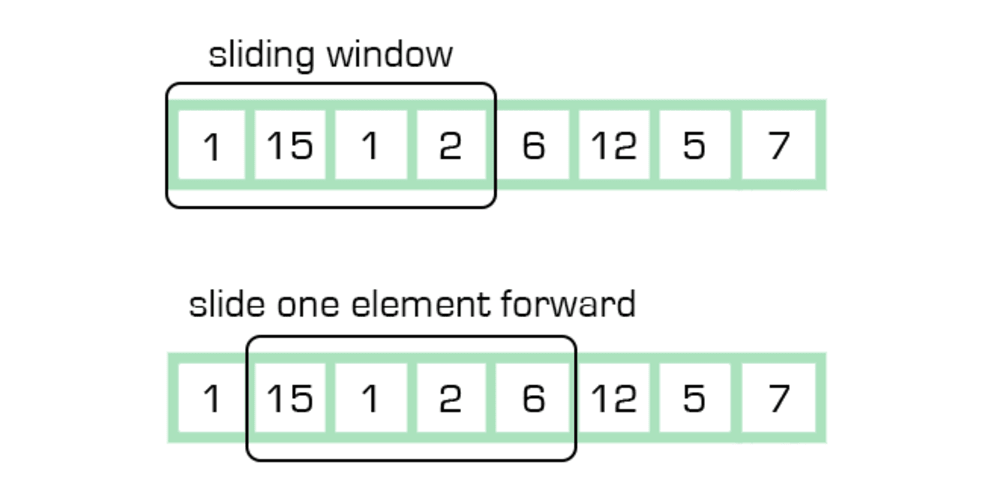

Some parameters can be specified for the tokenization:
- `max_length:` the maximum length of the input beyond which the input is truncated.
- `truncation:` if truncation is needed, you can specify whether to perform it on the context-question couple or on the answer.
- `stride:` If the context-question and answer exceeded the maximum length, it is possible to extract different sub-contexts by applying a stride with a dynamic window.
- `padding:` If the context and the question have a length less than the maximum length, some padding is added.

For example below, setting a maximum length of 25 and a stride of 10 we get 3 sub-contexts starting from the initial integer context because it exceeds the maximum length. With the truncation parameter we have specified that the truncation and the sliding window must be applied only on the context while the question is always entirely present.

In [14]:
context = "In meteorology, precipitation is any product of the condensation of atmospheric water vaport that falls under gravity."
question = "What causes precipitation to fall? "
answer = "Condensation of atmospheric water vaport that falls under gravity"
context_question = f"{context} {question}"
inputs = tokenizer(
        context_question, #context-question couple
        answer, #answer
        add_special_tokens=True,
        max_length=50,
        truncation="only_first",
        padding="max_length",
        return_tensors="pt",
        stride=stride
)

print("Embedding of the input: ")
print(inputs["input_ids"])

print("Length of embedding: ", len(inputs["input_ids"].squeeze()))

print("Given the embedding of the input, we can retrieve the initial text with the special tokens")
print(tokenizer.decode(inputs["input_ids"].squeeze()))

print("The end-of-text token is: ", tokenizer.decode(inputs["input_ids"].squeeze()[49]))

print("Sub-words tokenization: ", tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze()))

Embedding of the input: 
tensor([[  818, 19999,  1435,    11, 32025,   318,   597,  1720,   286,   262,
          1779, 25742,   286, 20938,  1660, 38187,   419,   326,  8953,   739,
         13522,    13,  1867,  5640, 32025,   284,  2121,    30,   220, 25559,
         25742,   286, 20938,  1660, 38187,   419,   326,  8953,   739, 13522,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]])
Length of embedding:  50
Given the embedding of the input, we can retrieve the initial text with the special tokens
In meteorology, precipitation is any product of the condensation of atmospheric water vaport that falls under gravity. What causes precipitation to fall? Condensation of atmospheric water vaport that falls under gravity<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
The end-of-text token is:  <|endoftext|>
Sub-words tokenization:  ['In', 'Ġmeteor', 'ology', ',', 'Ġprecipitatio

The following class defines an iterable object that makes more handy the preparation of the input for the training.

Each time an input is requested, a group context-question and answer is tokenized and the right input, in the form of a dictionary containing the embeddings and the attention mask, is obtained.

In [15]:
class ContextQuestionDataset(Dataset):
    def __init__(self, contexts, questions, answers, tokenizer):
        self.contexts = contexts
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.contexts)

    def __getitem__(self, index):
        # Retrieve a row of the dataset
        context = self.contexts[index]
        question = self.questions[index]
        answer = self.answers[index]

        # Combine context and question
        input_text = f"{context} {question}" 

        # Tokenize context-question and answer
        encoding = self.tokenizer(
            input_text,
            answer,
            add_special_tokens=True,
            max_length=max_length,
            truncation="only_first",
            padding="max_length",
            return_tensors="pt",
            return_overflowing_tokens=True,
            stride=stride
        )

        # Prepare the output
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()
        labels = encoding["input_ids"].squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

# Create an instance of the dataset
train_dataset = ContextQuestionDataset(train_dataset_contexts, train_dataset_questions, train_dataset_answers, tokenizer)

##Training

We create an instanec of the `GPT2LMHeadModel`.

In [16]:
model = GPT2LMHeadModel.from_pretrained(model_name)

We define TrainingArguments which allows us to set some parameters for training such as:
- `model_name`: the name under which the model will be saved.
- `save_strategy`: how often to save a checkpoint of the model, in our case at every epoch.
- `learning_rate`: learning rate used for training.
- `num_train_epochs`: number of epochs for training. In this case 3 have been chosen to limit the training time and thank to the pretrained model we start from.
- `weight_decay`: parameter to avoid overfitting.
- `fp16`: it allows for reducing memory usage and accelerating training by utilizing faster computational operations. **Note:** this requires a GPU.

In [17]:
from transformers import Trainer, TrainingArguments, default_data_collator

training_args = TrainingArguments(
    model_name+'_generative_question_answering',
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=learning_rate,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    fp16=True #to be used when Cuda is active
)

We just pass everything to the Trainer class using the Huggingface trainer API and launch the training

In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, 
    eval_dataset=valid_dataset, 
    data_collator=default_data_collator,
    tokenizer=tokenizer, 
)
trainer.train() #comment this line to avoid training. Note that GPU is needed. If want to use CPU, comment "fp16=True" in TrainingArguments
# Output: training time with completion bar

## Evaluation

Waiting for the training to end could last hours.. It may be useful to load a checkpoint from our previous training.

In [19]:
import torch

model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/distilgpt2_generative_question_answering/checkpoint-32559')
model.to(device) #move to device

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

The following function allows to generate a response from every context-question couple given as input. The `do_sample` parameter allows to sample between the best response instead of always respond with the best one.

In [20]:
def generate_answer(context, question, tokenizer, model, do_sample):
    # Create the input text
    input_text = f"{context} {question}" 

    # Encode the input
    input_ids = tokenizer.encode(input_text, add_special_tokens=True, return_tensors="pt")
    attention_mask = torch.ones_like(input_ids)  # Set attention mask to 1 for all tokens
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Generate the output
    output = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=1000, do_sample=do_sample, num_return_sequences=1)
    # Obtain the output as a string
    answer = tokenizer.decode(output[0], skip_special_tokens=True)

    # Return the last characters. The model infact will produce a string that starts with context-question and end with the answer
    return answer[len(input_text):]

Let's try the model with some examples. The context is now the description of the Natural Language Processing course from the official site. If you can't run the notebook, you can still see the output in the last comment.

In [ ]:
context = "Natural Language Processing (NLP) concerns the computational analysis, interpretation, and production of natural language in either written or spoken form. It is an interdisciplinary research field, interesting from both theoretical and practical perspectives. Decades of research have resulted in a vast collection of symbolic, stochastic, and deep-learning based models. Such models have enable the development of applications in a vast array of fields, such as human-machine interaction and chatbots, search and question answering, translation and multilingual systems, multimodal and captioning systems, speech analysis, voice interaction and personal assistants, sentiment analysis, etc, etc. This course will provide an introduction to the important problems, models and applications in NLP. The history of NLP involves many successes and many failures, demonstrating the complexity of the topic. Initially popular symbolic models turned out to be unable to capture the intrinsic complexity of natural language. Statistical techniques such as vector-space representations and linear classifiers (e.g. Support Vector Machines) enabled important applications such as web search spam detection. Word embedding techniques then became popular and improved performance on all aspects of NLP: from morphology to semantics and dialogue. More recently sequence-to-sequence modeling with deep learning techniques have greatly improved performance on hard NLP problems such machine translation and dialog generation."
question = "Who is the subject of the context?"
print(generate_answer(context, question, tokenizer, model,True))

# Output: "natural language processing"

In [ ]:
question = "Which statistical techniques are used?"
print(generate_answer(context, question, tokenizer, model,True))

# Output: "vector-space representations and linear classifiers"

In [ ]:
question = "What is Natural Language Processing about?"
print(generate_answer(context, question, tokenizer, model,True))

# Output: "what is an interdisciplinary research field, interesting from both theoretical and practical perspectives."

In [ ]:
question = "What is NLP?"
print(generate_answer(context, question, tokenizer, model,True))

# Output: "the study of natural language in either written or spoken form"

### Exact Match and F1

The model has been fine-tuned on the SQuAD dataset. On the official site, EM and F1 metrics are defined to rank the models provided by the users. We used these same metrics also in the other notebooks, so let's use them another time to compare the generative approach with the classification one.

An interesting approach is to compute the metrics using `do_sample=True` or `do_sample=False` to see how much this impact the result.

**Without** sampling:

In [ ]:
import evaluate
import collections
import numpy as np

predicted_answers = []
real_answers = []
for valid_group in valid_dataset:
    # set current id (this is necessary for the function that will compute the metrics)
    curr_id = valid_group['id']
    # put context and question together
    output_string = generate_answer(valid_group['context'], valid_group['question'], tokenizer, model, False)
    # save result
    predicted_answers.append({'id' : curr_id, 'prediction_text' : output_string})
    real_answers.append({'id' : curr_id, 'answers' : valid_group['answers']})

metric = evaluate.load("squad")
metric.compute(predictions=predicted_answers, references=real_answers)

# Output: {'exact_match': 52.16878632190685, 'f1': 19.68522591695285}

**With** sampling

In [ ]:
import evaluate
import collections
import numpy as np

predicted_answers = []
real_answers = []
for valid_group in valid_dataset:
    # set current id (this is necessary for the function that will compute the metrics)
    curr_id = valid_group['id']
    # put context and question together
    output_string = generate_answer(valid_group['context'], valid_group['question'], tokenizer, model, True)
    # save result
    predicted_answers.append({'id' : curr_id, 'prediction_text' : output_string})
    real_answers.append({'id' : curr_id, 'answers' : valid_group['answers']})

metric = evaluate.load("squad")
metric.compute(predictions=predicted_answers, references=real_answers)

# Output: {'exact_match': 31.575844352733093, 'f1': 35.09317847017492}

## Model comparisons

We trained and compared 2 types of models for the question answering task:
 - GPT2
 - DistilGPT2

In both cases, we implemented closed-domain (given a context and a question, answer to that question) and open-domain (given a question, answer to that question. In this case there is no knowledge given by the context) answer generation. In the closed-domain case we also trained both considering (SQuAD 2.0) and not considering (SQuAD 1.1) unanswerable questions. In the open-domain case we only dealed with answerable questions (SQuAD 1.1): this because here there is no concept of unanswerable question, being the domain open and not limited to a single context where to find the answer in. 

Hence, the models obtained are:
- GPT2 on closed-domain answer generation, SQuAD 1.1
- DistilGPT2 on closed-domain answer generation, SQuAD 1.1
- GPT2 on closed-domain answer generation, SQuAD 2.0
- DistilGPT2 on closed-domain answer generation, SQuAD 2.0
- GPT2 on open-domain answer generation, SQuAD 1.1
- DistilGPT2 on closed-domain answer generation, SQuAD 1.1 

For each one, we computed the metrics sampling the response among the best ones (namely with sampling) and taking strictly the best one (namely without sampling).

Since GPT2 is very complex with respect to DistilGPT, we slightly modified some parameters to adapt the training time:
 - GPT2: `max_length=384`, `stride=128`.
 - DistilGPT2: `max_length=512`, `stride=256`.

All other parameters are the same presented above (e.g. `num_epochs=3`).

To be coherent with the Question Answering task (classification), we still use the F1 and EM metrics. As expected, the performaces are way worse than the classification techniques, since here the answers are generated, and not copied from the contexts, characteristic required by EM and F1 to get good values.




### Closed-Domain Answer Generation without Unanswerable Questions (SquAD 1.1)

EM and F1. "s." stands for "sampling". This means that the answer chosen to compute the metric is not necessary the best (where best is intended as "the most probable answer for the model"), as explained above.

DistilGPT2  EM:  34.45  F1:  46.14
GPT2  EM:  60.0  F1:  61.54
DistilGPT2 s.  EM:  0.35  F1:  4.02
GPT2 s.  EM:  60.0  F1:  66.67


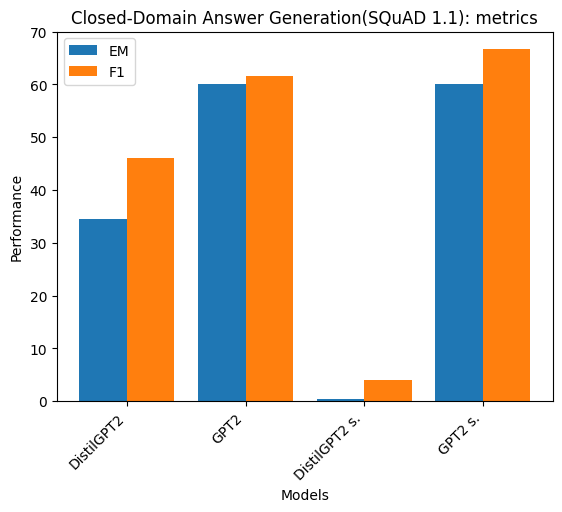

In [22]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['DistilGPT2', 'GPT2', 'DistilGPT2 s.', 'GPT2 s.']
em = [34.45, 60.0, 0.35, 60.0]
f1 = [46.14, 61.54, 4.02, 66.67]

for i in range(len(X)):
  print(X[i], " EM: ", em[i], " F1: ", f1[i])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, em, 0.4, label = 'EM')
plt.bar(X_axis + 0.2, f1, 0.4, label = 'F1')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Performance")
plt.title("Closed-Domain Answer Generation(SQuAD 1.1): Metrics")
plt.legend()
plt.show()

We can also make a comparison in terms of time requested by the training

NOTE: The values ​​of the performances, training time and number of parameters have been retrieved from the relative notebooks where the trainings of the single models have been carried out

DistilGPT2  Training time:  210  min
GPT2  Training time:  225  min


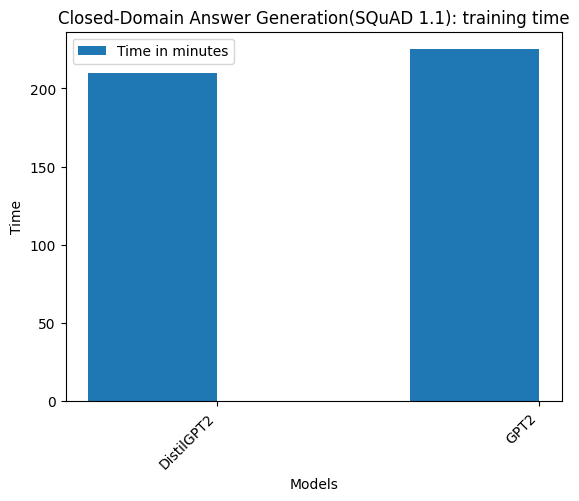

In [23]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['DistilGPT2', 'GPT2']
time = [210, 225]
  
for i in range(len(X)):
  print(X[i], " Training time: ", time[i], " min")

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, time, 0.4, label = 'Time in minutes')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Time")
plt.title("Closed-Domain Answer Generation(SQuAD 1.1): Training Time")
plt.legend()
plt.show()

And finally we can compare the number of parameters for each model

NOTE: The values ​​of the performances, training time and number of parameters have been retrieved from the relative notebooks where the trainings of the single models have been carried out

DistilGPT2  #Parameters:  81912576
GPT2  #Parameters:  124439808


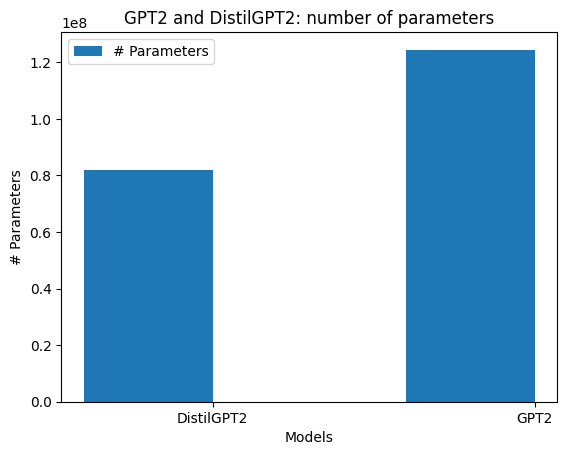

In [24]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['DistilGPT2', 'GPT2']
num_params = [81912576, 124439808]
  
for i in range(len(X)):
  print(X[i], " #Parameters: ", num_params[i])

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, num_params, 0.4, label = '# Parameters')
  
plt.xticks(X_axis, X)
plt.xlabel("Models")
plt.ylabel("# Parameters")
plt.title("GPT2 and DistilGPT2: Number of Parameters")
plt.legend()
plt.show()

### Closed-Domain Answer Generation with Unanswerable Questions (SquAD 2.0)

EM and F1:

DistilGPT2  EM:  52.17  F1:  19.69
GPT2  EM:  50.33  F1:  52.95
DistilGPT2 s.  EM:  31.58  F1:  35.09
GPT2 s.  EM:  32.81  F1:  33.72


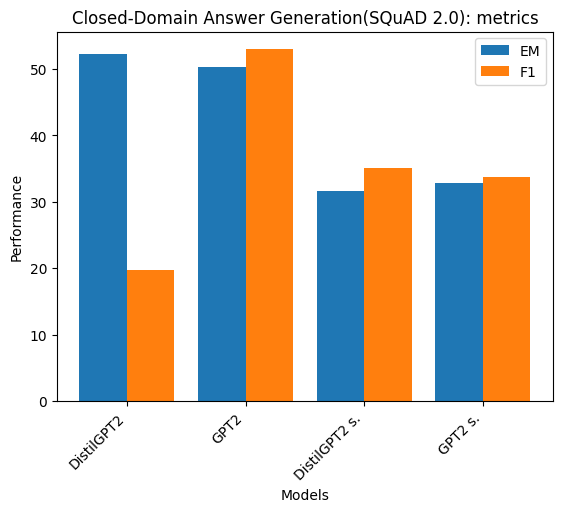

In [26]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['DistilGPT2', 'GPT2', 'DistilGPT2 s.', 'GPT2 s.']
em = [52.17, 50.33, 31.58, 32.81]
f1 = [19.69, 52.95, 35.09, 33.72]

for i in range(len(X)):
  print(X[i], " EM: ", em[i], " F1: ", f1[i])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, em, 0.4, label = 'EM')
plt.bar(X_axis + 0.2, f1, 0.4, label = 'F1')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Performance")
plt.title("Closed-Domain Answer Generation(SQuAD 2.0): Metrics")
plt.legend()
plt.show()

Time requested by the training:

DistilGPT2  Training time:  285  min
GPT2  Training time:  345  min


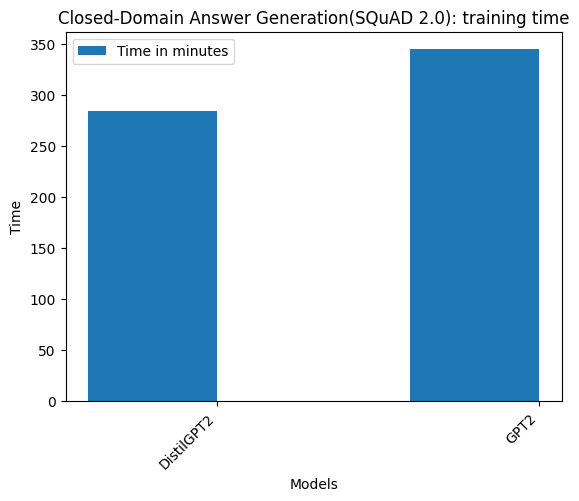

In [27]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['DistilGPT2', 'GPT2']
time = [285, 345]
  
for i in range(len(X)):
  print(X[i], " Training time: ", time[i], " min")

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, time, 0.4, label = 'Time in minutes')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Time")
plt.title("Closed-Domain Answer Generation(SQuAD 2.0): Training Time")
plt.legend()
plt.show()

The parameters are the same displayed above.

### Closed-Domain Answer Generation: SQuAD 1.1 VS SquAD 2.0

Let's put the previous results together to compare the models trained on SQuAD 1.1 and the ones trained on SQuAD 2.0 (considering on the without-sampling case):

DistilGPT2 S1  EM:  34.45  F1:  46.14
GPT2 S1  EM:  60.0  F1:  61.54
DistilGPT2 S2  EM:  52.17  F1:  19.69
GPT2 S2  EM:  50.33  F1:  52.95


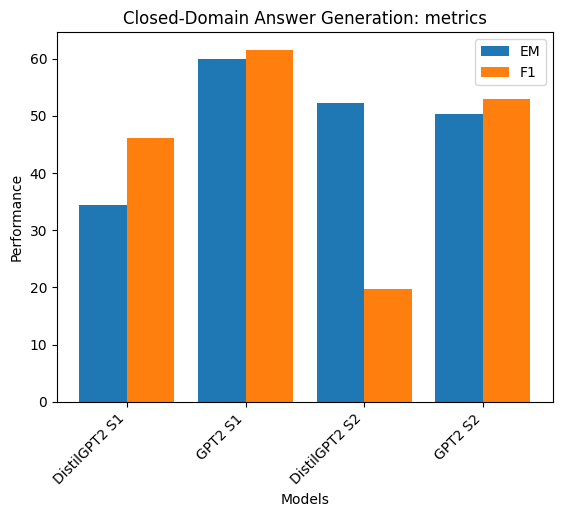

In [32]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['DistilGPT2 S1', 'GPT2 S1', 'DistilGPT2 S2', 'GPT2 S2']
em = [34.45, 60.0, 52.17, 50.33]
f1 = [46.14, 61.54, 19.69, 52.95]


for i in range(len(X)):
  print(X[i], " EM: ", em[i], " F1: ", f1[i])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, em, 0.4, label = 'EM')
plt.bar(X_axis + 0.2, f1, 0.4, label = 'F1')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Performance")
plt.title("Closed-Domain Answer Generation: Metrics")
plt.legend()
plt.show()

Time requested for the training:

DistilGPT2 S1  Training time:  210  min
GPT2 S1  Training time:  225  min
DistilGPT2 S2  Training time:  285  min
GPT2 S2  Training time:  345  min


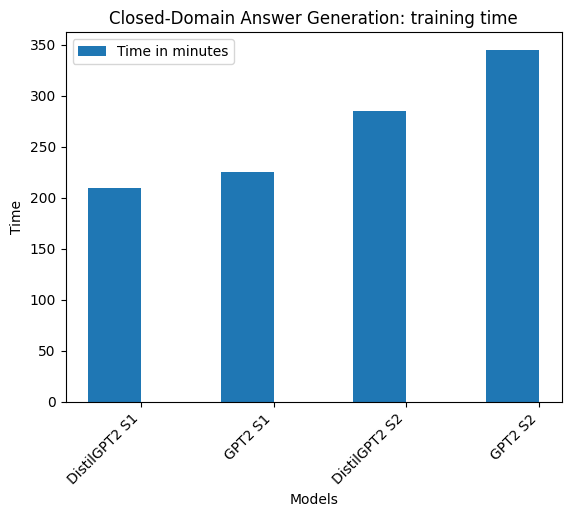

In [33]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['DistilGPT2 S1', 'GPT2 S1', 'DistilGPT2 S2', 'GPT2 S2']
time = [210, 225, 285, 345]
  
for i in range(len(X)):
  print(X[i], " Training time: ", time[i], " min")

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, time, 0.4, label = 'Time in minutes')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Time")
plt.title("Closed-Domain Answer Generation: Training Time")
plt.legend()
plt.show()

### Open-Domain Answer Generation

As expected, the performaces here drop even more: the context is no more avilable to the model, so the answer will be rarely equal to the answer expected by the validation.

EM and F1:

DistilGPT2  EM:  1.45  F1:  7.74
GPT2  EM:  2.21  F1:  9.1
DistilGPT2 s.  EM:  0.74  F1:  4.69
GPT2 s.  EM:  0.84  F1:  5.38


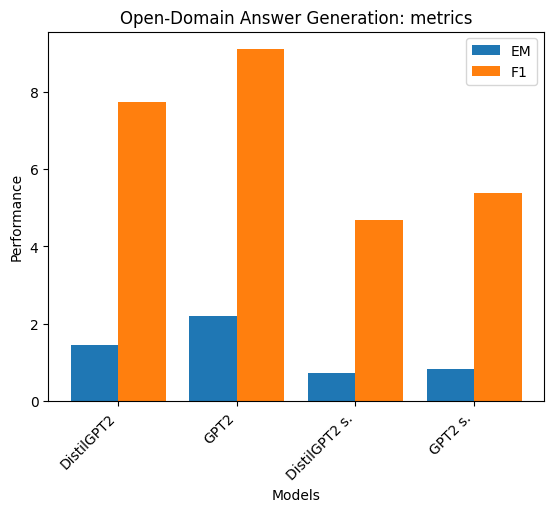

In [34]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['DistilGPT2', 'GPT2', 'DistilGPT2 s.', 'GPT2 s.']
em = [1.45, 2.21, 0.74, 0.84]
f1 = [7.74, 9.10, 4.69, 5.38]

for i in range(len(X)):
  print(X[i], " EM: ", em[i], " F1: ", f1[i])
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, em, 0.4, label = 'EM')
plt.bar(X_axis + 0.2, f1, 0.4, label = 'F1')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Performance")
plt.title("Open-Domain Answer Generation: Metrics")
plt.legend()
plt.show()

Training time:

DistilGPT2  Training time:  195  min
GPT2  Training time:  220  min


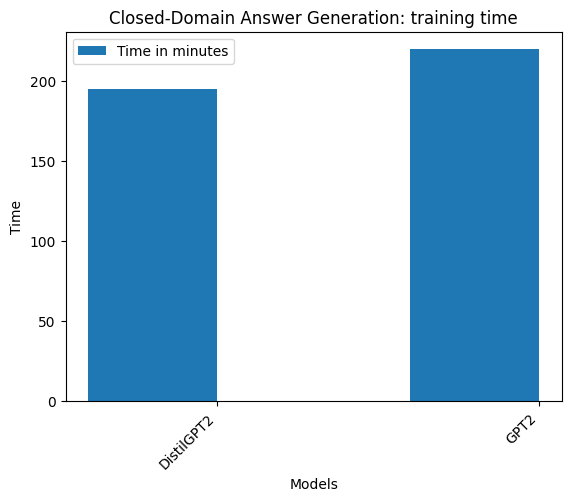

In [35]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['DistilGPT2', 'GPT2']
time = [195, 220]
  
for i in range(len(X)):
  print(X[i], " Training time: ", time[i], " min")

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, time, 0.4, label = 'Time in minutes')
  
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.xlabel("Models")
plt.ylabel("Time")
plt.title("Closed-Domain Answer Generation: Training Time")
plt.legend()
plt.show()